# Ion Analysis
In this notebook, we will do all of the analysis for the ions. We will start by computing the purity values associated with those atoms. We will then build new fragments around the ions that improve the purity. We will next develop a buffer region using the interaction spilling equations. Finally, we will set up a QM/MM type run on those atoms.

## Loading Of Data
This basic data structure will store all the matrices required.

In [1]:
from CheSS import Matrices as M

class blockparam:
    def __init__(self, folder):
        '''Initialize the parameters based on files.
        '''
        self.density_file = folder+"/density_kernel_sparse.mtx"
        self.hamiltonian_file = folder+"/hamiltonian_sparse.mtx"
        self.overlap_file = folder+"/overlap_sparse.mtx"
        self.metadata_file = folder+"/sparsematrix_metadata.dat"
        
    def build_lookup(self):
        '''Build a lookup list that gives you the basis functions for each atom.
        '''
        alookup = M.get_atomic_lookup(self.metadata_file)
        self.atom_to_basis = [[] for x in range(0, max(alookup)+1)]
        for basis, atom in enumerate(alookup):
            self.atom_to_basis[atom].append(basis)
    
    def read_matrices(self):
        '''Read in the files, build the overlap inverse.
        '''
        from scipy.io import mmread
        from scipy.sparse.linalg import inv
        self.overlap = mmread(self.overlap_file)
        self.density = mmread(self.density_file)
        self.hamiltonian = mmread(self.hamiltonian_file)
        self.KS = 0.5*self.density.dot(self.overlap).todense()
        self.sinv = inv(self.overlap)
        self.sinvxh = self.sinv.dot(self.hamiltonian)
        self.sinvxh2 = self.sinvxh.dot(self.sinvxh)

In [2]:
data = blockparam("Matrices")
data.build_lookup()
data.read_matrices()
geom_file = "Matrices/1L2Y.yaml"
image_size = (12,4)

/usr/local/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python2.7/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [3]:
import yaml
purity_file = "PurityData/Single/1L2Y.yaml"
with open(purity_file) as ifile:
    bigdft_purity = yaml.load(ifile)

Build the fragment data structure.

In [4]:
from BigDFT import Fragments as F
from yaml import load
with open(geom_file) as ifile:
    sys = load(ifile)
    positions = sys["Reading positions"].itervalues().next()
fdict = F.CreateFragDict(positions)

We also will load the charge values in from BigDFT

In [5]:
def lookup_fragment(fdict, atomlist):
    for fragname in fdict:
        for fragid, atoms in fdict[fragname].items():
            if set(atomlist) == set(atoms):
                return fragname, fragid

In [6]:
cdict = {}
for frag in bigdft_purity["Fragment multipoles"]:
    neutral_charge = frag["Neutral fragment charge"]
    q0 = frag["q0"]
    net_charge = neutral_charge + q0[0]
    atomlist = frag["Atom IDs"]
    fragname, fragid = lookup_fragment(fdict, atomlist)
    if not fragname in cdict:
        cdict[fragname] = {}
    cdict[fragname][fragid] = net_charge

I have also generated the bader charge dipole values for each atom.

In [7]:
bader_file = "bader.yaml"
with open(bader_file) as ifile:
    bader_data = load(ifile)["positions"]
bader_values = []
for atom in bader_data:
    bader_values.append(float(atom["Charge net"]))

## Purity Analysis
Now we will compute the purity values, and in particular we'll focus on the purity values of the Chlorine atoms. First a charge lookup data structure.

In [8]:
from numpy import zeros
electron_lookup = {'H' :1, 'He':2, 
                   'Li':1, 'Be':2, 'B' :3, 'C': 4, 'N':5, 'O':6, 'F' :7, 'Ne':8,
                   'Na':1, 'Mg':2, 'Al':3, 'Si':4, 'P':5, 'S':6, 'Cl':7}
natoms = len(positions["positions"])
charge = zeros((natoms))
for i, p in enumerate(positions["positions"]):
    name = p.keys()[1]
    charge[i] = electron_lookup[name]

A list of fragments.

In [9]:
frag_list = []
for fname in fdict.keys():
    for fid in fdict[fname].keys():
        frag_list.append(fdict[fname][fid])

The subroutine used to compute the purity values.

In [10]:
def compute_purity(param, charge, frag):
    from numpy import zeros
    from numpy import trace
    from scipy.sparse import csr_matrix
    if (len(frag)) == 0:
        return 0
    indices = []
    cv = 0
    for atom in frag:
        indices += param.atom_to_basis[atom-1]
        cv += charge[atom-1]

    submat = param.KS[indices,:]
    submat = submat[:,indices]
    
    return 2*trace(submat.dot(submat) - submat)/cv

Compute and plot.

In [11]:
purity_values = []
for frag in frag_list:
    purity_values.append(compute_purity(data, charge, frag))

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(sorted(purity_values), 'x')
ax.set_title("Purity Values")
ax.set_xlabel("Fragment ID")

### The Chlorine Purity Values
Now we will do that same plot but show where the Chlorine atoms sit on that scale.

In [13]:
target_list = []
for fname in fdict.keys():
    if not (fname == "CLA" or fname == "SOD"):
        continue
    for fid in fdict[fname].keys():
        target_list.append(fdict[fname][fid])

In [14]:
target_purity = []
for frag in target_list:
    target_purity.append(compute_purity(data, charge, frag))

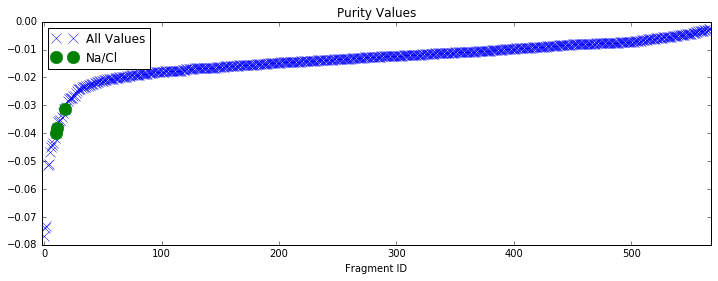

In [15]:
from matplotlib import pyplot as plt

# find chlorine values in the sorted list
spv = sorted(purity_values)
x_cl = []
for k in range(0, len(target_list)):
    for i in range(0, len(purity_values)):
        if target_purity[k] == spv[i]:
            x_cl.append(i)
            break

fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(sorted(purity_values), 'x', markersize=10, label="All Values")
ax.plot(x_cl, target_purity, '.', markersize=25, label="Na/Cl")
ax.set_xlim(-2,len(purity_values))
ax.set_title("Purity Values")
ax.set_xlabel("Fragment ID")
plt.legend(loc="best")

## Refragmentation of Chlorine
Next we will try to add some neighboring water molecules to the Chlorine atoms to improve the purity values. First, a subroutine to get nearest neighbors.

In [16]:
def GetNearest(fragtuple, sysfile, threshold=None, number=None):
    import numpy as np
    sys = F.System(posinp_dict=sysfile)
    for f in sys.fragments:
        if f.id == F.SetFragId(*fragtuple):
            our_frag = f
            break
    distance_array =[F.distance(our_frag, f, cell=sysfile["cell"]) for f in sys.fragments]
    ipiv = np.argsort(distance_array)
    if number:
        shell = ipiv[:number]
    else:
        shell = np.where(np.array(distance_array) < threshold)[0]
    shellid = [sys.fragments[s].id for s in shell]
    return shellid

Fragment tuples.

In [17]:
frag_tuples = []
for fname in fdict.keys():
    if not (fname == "CLA" or fname == "SOD"):
        continue
    for fid in fdict[fname].keys():
        frag_tuples.append((fname, fid))

Next we will compute the purity values for the Chlorine+Water fragments.

In [24]:
merged_purity = []
merged_charge = []
merged_bader = []
for cl in frag_tuples:
    merged_purity.append([])
    merged_charge.append([])
    merged_bader.append([])
    for num_neighbors in range(0, 10):
        neighbor_list = GetNearest(cl, positions, number=num_neighbors+1)
        tlist = []
        total_charge = 0
        for n in neighbor_list:
            fname, fid = n.split(":")
            tlist.extend(fdict[fname][int(fid)])
            total_charge += cdict[fname][int(fid)]
        merged_purity[-1].append(compute_purity(data, charge, tlist))
        merged_charge[-1].append(total_charge)
        total_bader = 0
        for atom in tlist:
            total_bader += bader_values[atom-1]
        merged_bader[-1].append(total_bader)

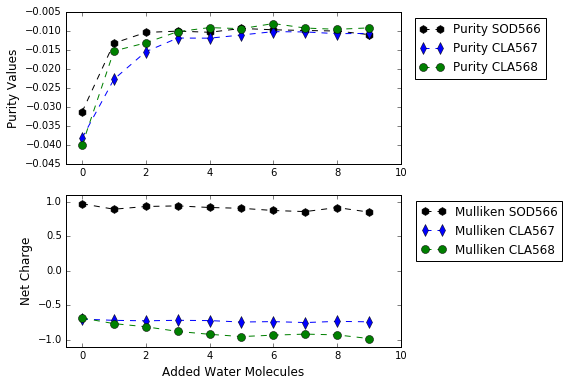

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))

marker = ["o--", "d--", "h--"]
marker2 = ["*--", "s--", "8--"]
colors= ['g', 'b', 'black']

for i in range(len(frag_tuples)-1, -1, -1):
    name = frag_tuples[i][0]+str(frag_tuples[i][1])
    ax[0].plot(merged_purity[i], marker[i], label="Purity "+name, color=colors[i], markersize=8)
    ax[1].plot(merged_charge[i], marker[i], label="Mulliken "+name, color=colors[i],  markersize=8)
#     ax[1].plot(merged_bader[i], marker2[i], label="Bader "+name, color=colors[i],  markersize=8)
ax[0].set_xlim(-0.5, len(merged_purity[0]))
ax[1].set_xlim(-0.5, len(merged_purity[0]))
ax[1].set_ylim(-1.1, 1.1)
ax[1].set_xlabel("Added Water Molecules",fontsize=12)
ax[0].set_ylabel("Purity Values",fontsize=12)
ax[1].set_ylabel("Net Charge",fontsize=12)
ax[0].legend(bbox_to_anchor=(1.45,1), ncol=1)
ax[1].legend(bbox_to_anchor=(1.5,1), ncol=1)
plt.savefig("Pictures/ChlorineRefrag.eps", bbox_inches='tight')

## Buffer Region
Now we will construct the buffer region using the spillage information. First, the subroutine for doing the calculation.

In [ ]:
def compute_spillage(param, frag_F, frag_list):
    from numpy import trace
    val_list = []
    if (len(frag_F)) == 0:
        return 0
    indices_f = []
    
    for atom in frag_F:
        indices_f += param.atom_to_basis[atom-1]
            
    denom = param.sinvxh[:,indices_f]
    denom = denom[indices_f,:]
    denom = denom.todense()
    denom = denom.dot(denom)
    denom_t = trace(denom)

    H2T = param.sinvxh2[:,indices_f]
    H2T = H2T[indices_f,:]
    left_t = trace(H2T.todense())
    
    for frag_G in frag_list:
        indices_g = []
        for atom in frag_G:
            indices_g += param.atom_to_basis[atom-1]
        
        TFH = param.sinvxh[indices_f,:]
        TFHTG = TFH[:,indices_g].todense()
    
        TGH = param.sinvxh[indices_g,:]
        TGHTF = TGH[:,indices_f].todense()
        
        right_mat = (TFHTG.dot(TGHTF))
        val = trace(right_mat)
        val_list.append(val)

    return left_t, val_list, denom_t, 
    

And a helpful data structure for using this routine.

In [ ]:
class spillage_info():
    def __init__(self, name, frag_dict, target):
        self.name = name
        self.frag_dict = frag_dict
        self.target = target
        self.frag_list = []
        for fname in self.frag_dict.keys():
            for fid in self.frag_dict[fname].keys():
                self.frag_list.append(self.frag_dict[fname][fid])
    def compute_spillage(self, data):
        self.left, self.val_list, self.denom = compute_spillage(data, self.target, self.frag_list)
    def plot(self, ax, marker):
        ax.plot(sorted(self.val_list, reverse=True)/self.denom, marker, markersize=10, label=self.name)
        

Judging by the purity and charge values, it seems like adding three water molecules to the Chlorines is safe.

In [ ]:
from copy import deepcopy
fdict = F.CreateFragDict(positions)

Cl_targets = deepcopy(fdict)
tname = "Ion-Cluster"
Cl_targets[tname] = {}
for i in range(0, len(frag_tuples)):
    fname, fid = frag_tuples[i][0], frag_tuples[i][1]
    Cl_targets[tname][fid] = deepcopy(fdict[fname][fid])
    
    del Cl_targets[fname][fid]
    if not Cl_targets[fname]:
        del Cl_targets[fname]
        
    neighbor_list = GetNearest(frag_tuples[i], positions, number=3+1)
    for nei in neighbor_list[1:]:
        nname, nid = nei.split(":")
        Cl_targets[tname][fid] += fdict[nname][int(nid)]
        
        if nname in Cl_targets:
            del Cl_targets[nname][int(nid)]
            if not Cl_targets[nname]:
                del Cl_targets[nname]
print(Cl_targets["Ion-Cluster"])

In [ ]:
spillage_list = []
for i in range(0, len(frag_tuples)):
    fname, fid = frag_tuples[i][0], frag_tuples[i][1]
    spillage_list.append(spillage_info(tname+" "+str(fid), Cl_targets, Cl_targets[tname][fid]))
    spillage_list[i].compute_spillage(data)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.set_yscale("log")
marker = [".", "x", 'h']
for i in range(len(frag_tuples)-1, -1, -1):
    spillage_list[i].plot(ax, marker[i])
ax.set_xlim(-3,150)
ax.set_ylim(1e-8, 5)
ax.legend(loc="best")

### Extract Buffer
With the spillage values calculated, we can now extract a buffer of a given threshold.

In [ ]:
def generate_buffer(target, threshold):
    from numpy import array
    merge = []
    sval = []
    for v in array(target.val_list).argsort()[::-1]:
        if abs(target.val_list[v])/target.denom > threshold:
            merge += target.frag_list[v]
            sval.append(target.val_list[v])
        else:
            break
    return merge, sval

In [ ]:
thresh_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
regions = []
for i in range(0, len(frag_tuples)):
    regions.append({})
    for threshold in thresh_list:
        buf, sval = generate_buffer(spillage_list[i], threshold)
        regions[i][threshold] = list(buf)

## Build The BigDFT Input File

Copy the basic input parameters. 

In [ ]:
from yaml import load, dump
minimal_file = "QMMMInput/input_minimal.yaml"
with open(minimal_file) as ifile:
    inparam = load(ifile)
with open(log_file) as ifile:
    multipole_param = load(ifile)

In [ ]:
psp_keys = [k for k in inparam.keys() if "psppar" in k]
input_keys = ["dft", "chess", "perf", "lin_general", 
              "lin_basis", "lin_kernel", "lin_basis_params",
              "ig_occupation", "chess", "psolver", 
              "output", "kpt", "geopt", "md", "mix", 
              "sic", "tddft", "mode"]
input_keys.extend(psp_keys)

parameters = {k: v for k, v in inparam.items() if k in input_keys}
print(parameters.keys())

Fill in the position values.

In [ ]:
def fill_positions(positions, target_atoms):
    new_p_values = {}
    new_p_values["cell"] = positions["cell"]
    new_p_values["positions"] = []
    for t in target_atoms:
        atom = positions["positions"][t-1]
        atom = {atom.keys()[1]: atom[atom.keys()[1]]}
        new_p_values["positions"].append(atom)
    return new_p_values

Copy only the multipole values that aren't part of the target/buffer region.

In [ ]:
def fill_multipoles(multipole_param, target_atoms):
#     new_m_values = deepcopy()
    new_m_values = deepcopy(multipole_param)
    new_m_values["values"] = []

    for v in range(0, len(multipole_param["values"])):
        if v in target_atoms:
            continue
        new_m_values["values"].append(multipole_param["values"][v])
    return new_m_values

Main Loop over thresholds.

In [ ]:
from yaml import dump

for thresh in thresh_list:
    target_atoms = deepcopy(regions[0][thresh])
    for atom in regions[2][thresh]:
        if not atom in target_atoms:
            target_atoms.append(atom)
    new_p_values = fill_positions(positions, target_atoms)
    new_m_values = fill_multipoles(multipole_param["Multipole coefficients"], target_atoms)
    parameters["dft"]["external_potential"] = deepcopy(new_m_values)
    parameters["posinp"] = deepcopy(new_p_values)
    
    parameters["dft"]["external_potential"] = deepcopy(new_m_values)
    parameters["posinp"] = deepcopy(new_p_values)

    # Write To File
    output = "QMMMInput/input_qmmm-"+str(thresh)+".yaml"
    with open(output, "w") as ofile:
        dump(parameters,ofile)
        
    # Write Frag File For Analysis
    frag_output = "QMMMInput/frag-"+str(thresh)+".yaml"
    with open(frag_output, "w") as ofile:
        ofile.write("- " + str(range(0,10)))
        ofile.write("\n")
        offset = len(regions[0][thresh])
        ofile.write("- " + str(range(offset,offset+10)))
        ofile.write("\n")
        
    # Write out the XYZ file for visualization
    xyz_file = "QMMMInput/position-"+str(thresh)+".xyz"
    with open(xyz_file, "w") as ofile:
        ofile.write(str(len(new_p_values["positions"]))+" ")
        ofile.write(positions["units"])
        ofile.write("\n")
        ofile.write("".join([str(x)+" " for x in positions["cell"]]))
        ofile.write("\n")
        for atom in new_p_values["positions"]:
            species = atom.keys()[0]
            pos = " ".join([str(x) for x in atom[species]])
            ofile.write(species+"\t"+pos)
            ofile.write("\n")